In [1]:
### loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import IPython.display as ipd 

from tqdm import tqdm
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler  

from sklearn.inspection import permutation_importance
import shap
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score


import math


In [4]:
def get_results(truth, prediction, df, idx):
    

    acc = accuracy_score(truth, prediction)
    f1 = f1_score(truth, prediction)
    precision = precision_score(truth, prediction)
    recall = recall_score(truth, prediction)

    df.loc[idx,:] = [acc, f1, precision, recall]

    return df


In [2]:
df = pd.read_csv("../Data/Full_train_test_split/df_full_end_test_classification.csv")
df = df.drop(columns = ["Unnamed: 0","texts","standardised_texts", "1_hr_std","2_hr_std","3_hr_std","1_hr","2_hr","3_hr",
                        "4_hr","5_hr","6_hr","7_hr","8_hr","9_hr","10_hr","11_hr","12_hr","13_hr","14_hr","15_hr","16_hr",
                       "17_hr","18_hr","19_hr","20_hr","21_hr","22_hr","23_hr","24_hr","25_hr","26_hr","27_hr","28_hr"])
df['chunk'] = pd.to_datetime(df['chunk'], format = "%Y-%m-%d %H:%M:%S")
df['hour'] = df['chunk'].dt.hour
df['weekday'] = df['chunk'].dt.dayofweek
df['weekday'] = df['weekday'].astype("category")
df = df.drop(columns = ["chunk"])
df

,temp_weighted,cloud_cover_weighted,rainfall_weighted,polarity,abnormal,daily_policy_index,4_hr_std,5_hr_std,6_hr_std,7_hr_std,...,22_hr_std,23_hr_std,24_hr_std,25_hr_std,26_hr_std,27_hr_std,28_hr_std,train_test,hour,weekday
0,6.034263,21.525829,0.000000,0.043212,0,131.03,-0.437480,0.710856,1.819656,0.310877,...,0.119687,0.710595,-0.945563,-0.993749,-1.476664,-2.205763,-2.205763,train,19,4
1,5.561813,16.283735,0.000000,0.043212,0,131.03,-0.024752,-0.437480,0.710856,1.819656,...,-0.537640,0.119687,0.710595,-0.945563,-0.993749,-1.476664,-1.476664,train,20,4
2,5.399833,17.538188,0.000000,0.043212,0,131.03,-1.372619,-0.024752,-0.437480,0.710856,...,0.343245,-0.537640,0.119687,0.710595,-0.945563,-0.993749,-0.993749,train,21,4
3,4.787232,10.768733,0.000000,0.043212,0,131.03,-0.601068,-1.372619,-0.024752,-0.437480,...,-0.550993,0.343245,-0.537640,0.119687,0.710595,-0.945563,-0.945563,train,22,4
4,4.534415,11.672903,0.000000,0.043212,0,131.03,0.417116,-0.601068,-1.372619,-0.024752,...,0.149792,-0.550993,0.343245,-0.537640,0.119687,0.710595,0.710595,train,23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31653,15.699359,68.289117,0.111107,0.126059,0,237.37,1.253461,0.491539,0.483600,-0.892592,...,1.302787,1.464781,1.938614,1.548797,1.155023,1.471810,1.471810,test,16,0
31654,15.575034,65.451526,0.049704,0.126059,0,237.37,0.514161,1.253461,0.491539,0.483600,...,2.359881,1.302787,1.464781,1.938614,1.548797,1.155023,1.155023,test,17,0
31655,15.467610,65.150885,0.009647,0.126059,0,237.37,-0.053325,0.514161,1.253461,0.491539,...,2.276413,2.359881,1.302787,1.464781,1.938614,1.548797,1.548797,test,18,0
31656,15.052595,62.547601,0.036866,0.126059,0,237.37,-0.091542,-0.053325,0.514161,1.253461,...,0.712996,2.276413,2.359881,1.302787,1.464781,1.938614,1.938614,test,19,0


In [3]:
train = df.loc[df['train_test'] == "train"]
test = df.loc[df['train_test'] == "test"]

In [4]:
y_train = train.pop("abnormal")
X_train = train
X_train = X_train.drop(columns = ["train_test"])
y_test = test.pop("abnormal")
X_test = test
X_test = X_test.drop(columns = ["train_test"])

In [7]:
results = pd.DataFrame(index = ['Random Forest'], 
                       columns = ['accuracy', 'f1', 'precision', 'recall'])

In [8]:
parameters = {'max_features':['sqrt'], 'n_estimators':[1000],
              'max_depth':range(2,10),'min_samples_leaf':[2,4,8,16,32,64], 
              'criterion' :['gini', 'entropy'], 'class_weight':[{0:1, 1:4}, {0:1, 1:20}, {0:1, 1:1}, {0:1, 1:10}, {0:1, 1:7}]}

rf_class = GridSearchCV(RandomForestClassifier(random_state = 8),
                        parameters, n_jobs=7, scoring = 'f1')
rf_class.fit(X=X_train, y=y_train)
rf_model = rf_class.best_estimator_

#rf_model = RandomForestClassifier(n_estimators=1000, max_depth = 10, class_weight={0:1, 1:20}, random_state=13,
#                                  min_samples_leaf = 16)
rf_model.fit(X=X_train, y=y_train)

y_pred = rf_model.predict(X_test)

## Convert strings to ints to work with accuracy score functions

results = get_results(y_test, y_pred, results, 'Random Forest')


#print('The best parameters are {}'.format(rf_class.best_params_))
print(results)

               accuracy       f1 precision    recall
Random Forest  0.982736  0.46281  0.388889  0.571429


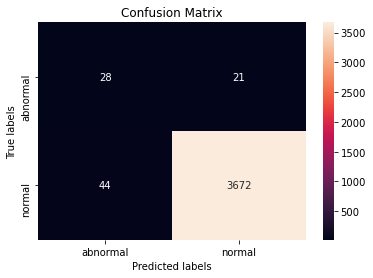

In [9]:
## Accuracy

labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks#
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['abnormal', 'normal']) 
ax.yaxis.set_ticklabels(['abnormal', 'normal'])

plt.show()


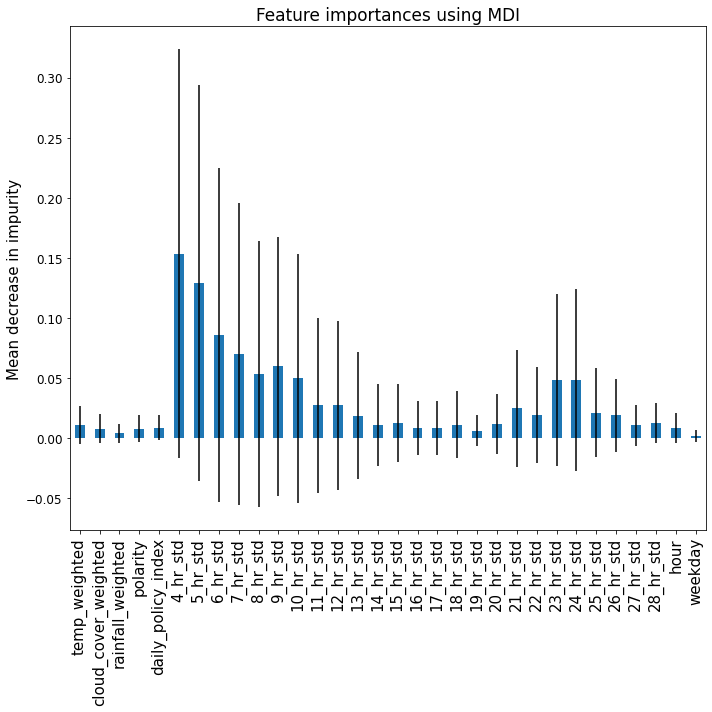

In [15]:
feature_names = X_train.columns
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI", fontsize=17)
ax.set_ylabel("Mean decrease in impurity", fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize=12)
fig.tight_layout()

plt.savefig("../Plots/feature_importances.pdf")

In [ ]:
plot_roc_curve(rf_model,X_test,y_test)
plt.show()

In [12]:
y_score = rf_model.predict_proba(X_test)

In [13]:
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ["index"])
y_test = y_test.squeeze()

y_pred = pd.Series(y_pred)

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_score[indices, 1])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))


sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Bootstrap #1 ROC area: 0.921
Bootstrap #2 ROC area: 0.943
Bootstrap #3 ROC area: 0.945
Bootstrap #4 ROC area: 0.957
Bootstrap #5 ROC area: 0.957
Bootstrap #6 ROC area: 0.930
Bootstrap #7 ROC area: 0.954
Bootstrap #8 ROC area: 0.943
Bootstrap #9 ROC area: 0.925
Bootstrap #10 ROC area: 0.953
Bootstrap #11 ROC area: 0.921
Bootstrap #12 ROC area: 0.949
Bootstrap #13 ROC area: 0.931
Bootstrap #14 ROC area: 0.975
Bootstrap #15 ROC area: 0.924
Bootstrap #16 ROC area: 0.935
Bootstrap #17 ROC area: 0.929
Bootstrap #18 ROC area: 0.905
Bootstrap #19 ROC area: 0.933
Bootstrap #20 ROC area: 0.916
Bootstrap #21 ROC area: 0.941
Bootstrap #22 ROC area: 0.925
Bootstrap #23 ROC area: 0.942
Bootstrap #24 ROC area: 0.962
Bootstrap #25 ROC area: 0.954
Bootstrap #26 ROC area: 0.953
Bootstrap #27 ROC area: 0.939
Bootstrap #28 ROC area: 0.953
Bootstrap #29 ROC area: 0.948
Bootstrap #30 ROC area: 0.915
Bootstrap #31 ROC area: 0.967
Bootstrap #32 ROC area: 0.946
Bootstrap #33 ROC area: 0.937
Bootstrap #34 ROC a

Bootstrap #301 ROC area: 0.951
Bootstrap #302 ROC area: 0.935
Bootstrap #303 ROC area: 0.942
Bootstrap #304 ROC area: 0.942
Bootstrap #305 ROC area: 0.951
Bootstrap #306 ROC area: 0.944
Bootstrap #307 ROC area: 0.971
Bootstrap #308 ROC area: 0.965
Bootstrap #309 ROC area: 0.943
Bootstrap #310 ROC area: 0.955
Bootstrap #311 ROC area: 0.923
Bootstrap #312 ROC area: 0.947
Bootstrap #313 ROC area: 0.939
Bootstrap #314 ROC area: 0.966
Bootstrap #315 ROC area: 0.969
Bootstrap #316 ROC area: 0.912
Bootstrap #317 ROC area: 0.929
Bootstrap #318 ROC area: 0.962
Bootstrap #319 ROC area: 0.947
Bootstrap #320 ROC area: 0.935
Bootstrap #321 ROC area: 0.952
Bootstrap #322 ROC area: 0.949
Bootstrap #323 ROC area: 0.953
Bootstrap #324 ROC area: 0.948
Bootstrap #325 ROC area: 0.910
Bootstrap #326 ROC area: 0.914
Bootstrap #327 ROC area: 0.943
Bootstrap #328 ROC area: 0.944
Bootstrap #329 ROC area: 0.928
Bootstrap #330 ROC area: 0.941
Bootstrap #331 ROC area: 0.929
Bootstrap #332 ROC area: 0.919
Bootstra

Bootstrap #597 ROC area: 0.950
Bootstrap #598 ROC area: 0.957
Bootstrap #599 ROC area: 0.930
Bootstrap #600 ROC area: 0.970
Bootstrap #601 ROC area: 0.923
Bootstrap #602 ROC area: 0.953
Bootstrap #603 ROC area: 0.948
Bootstrap #604 ROC area: 0.918
Bootstrap #605 ROC area: 0.956
Bootstrap #606 ROC area: 0.950
Bootstrap #607 ROC area: 0.927
Bootstrap #608 ROC area: 0.941
Bootstrap #609 ROC area: 0.961
Bootstrap #610 ROC area: 0.932
Bootstrap #611 ROC area: 0.948
Bootstrap #612 ROC area: 0.926
Bootstrap #613 ROC area: 0.914
Bootstrap #614 ROC area: 0.956
Bootstrap #615 ROC area: 0.940
Bootstrap #616 ROC area: 0.939
Bootstrap #617 ROC area: 0.939
Bootstrap #618 ROC area: 0.938
Bootstrap #619 ROC area: 0.944
Bootstrap #620 ROC area: 0.961
Bootstrap #621 ROC area: 0.959
Bootstrap #622 ROC area: 0.941
Bootstrap #623 ROC area: 0.934
Bootstrap #624 ROC area: 0.955
Bootstrap #625 ROC area: 0.904
Bootstrap #626 ROC area: 0.938
Bootstrap #627 ROC area: 0.967
Bootstrap #628 ROC area: 0.938
Bootstra

Bootstrap #896 ROC area: 0.952
Bootstrap #897 ROC area: 0.919
Bootstrap #898 ROC area: 0.936
Bootstrap #899 ROC area: 0.949
Bootstrap #900 ROC area: 0.945
Bootstrap #901 ROC area: 0.937
Bootstrap #902 ROC area: 0.933
Bootstrap #903 ROC area: 0.960
Bootstrap #904 ROC area: 0.942
Bootstrap #905 ROC area: 0.907
Bootstrap #906 ROC area: 0.952
Bootstrap #907 ROC area: 0.929
Bootstrap #908 ROC area: 0.939
Bootstrap #909 ROC area: 0.958
Bootstrap #910 ROC area: 0.955
Bootstrap #911 ROC area: 0.968
Bootstrap #912 ROC area: 0.941
Bootstrap #913 ROC area: 0.977
Bootstrap #914 ROC area: 0.930
Bootstrap #915 ROC area: 0.963
Bootstrap #916 ROC area: 0.971
Bootstrap #917 ROC area: 0.954
Bootstrap #918 ROC area: 0.960
Bootstrap #919 ROC area: 0.940
Bootstrap #920 ROC area: 0.969
Bootstrap #921 ROC area: 0.945
Bootstrap #922 ROC area: 0.936
Bootstrap #923 ROC area: 0.948
Bootstrap #924 ROC area: 0.930
Bootstrap #925 ROC area: 0.963
Bootstrap #926 ROC area: 0.940
Bootstrap #927 ROC area: 0.953
Bootstra

In [5]:
import joblib
#joblib.dump(rf_model, "random_forest.joblib")

In [6]:
rf_model = joblib.load("random_forest.joblib")

In [17]:
sum(rf_model.predict(X_test))

72

In [10]:
preds = pd.DataFrame(rf_model.predict(X_test), columns = ['Abnormal_preds'])

In [11]:
preds.to_csv('../Data/Random_Forest_preds.csv')